## LightGBM

#### XGBoostと比較して，動作が軽量で大規模データの学習に強い．
#### 一方で，LightGBMは，多くのハイパーパラメータを持つため，ハイパーパラメータチューニングが重要．

#### xgboostと比較すると，速度は早く，精度は同程度と考えられている．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import math
import urllib.request
import time

import scipy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import lightgbm as lgb
import gc

In [2]:
df = pd.read_csv('..//Data-science//data//boston.csv')

X = df[['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT']]
y = df['house prices']

# 標準化
X = pd.DataFrame(scipy.stats.zscore(X),index=X.index, columns=X.columns)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### 決定木をベースにしたモデルは，大小関係が保存される変換は学習にはほとんど影響がない．
#### 線形モデルではスケールが大きい変数ほど，その回帰係数が小さくなるため標準化を行わないと，そのような変数に対しても，正則化がかかりにくくなる．

## ベイズ最適化によるハイパーパラメータ探索

### Training API を利用する
#### 学習にはtrain() を使用する

### 使い方
- lgb.Dataset()でDatasetオブジェクトを作成
- ハイパーパラメータを辞書として用意する
- lgb.train()にDatasetオブジェクトとハイパーパラメータ辞書を渡す

In [4]:
params = {
    "objective": "regression",
    "metrics": {"rmse",'r2'},
    "verbose": -1
}

#### ハイパーパラメータ
- task: デフォルトは"train"．"train", "prediction", "refit"などから選択できる
- boosting_type:デフォルトは"gbdt"(Gradient Boosting Decision Tree)を使用できる．"rm"でランダムフォレストを使用できる．
- objective:"regression"(回帰)，"binary"(二値分類)，"multiclass"(多クラス分類)
- metric:損失関数．"rmse"，"binary_logloss"，"multi_logloss"
- num_leaves
- min_data_in_leaf
- max_depth

#### 学習データ,テストデータとparamsを渡して、エポック数などの訓練に関するパラメータを設定する

In [5]:
valid_socres = []
rmse_list = []
r2_list = []
models = []
kf = KFold(n_splits=5, shuffle=False)


for fold, (train_index, valid_index) in enumerate(kf.split(X_train)):
    
    X_tr, X_val = X_train[train_index], X_train[valid_index] 
    y_tr, y_val = y_train[train_index], y_train[valid_index]


    trains = lgb.Dataset(data=X_tr, label=y_tr, feature_name='auto') # dataにはテストデータ，labelには正解データ
    evals = lgb.Dataset(data=X_val, label=y_val, feature_name='auto') # feature_name=’auto’とすることで DataFrameの列名が認識される
    
    model = lgb.train(
        params,
        trains,
        valid_sets=evals,
        num_boost_round=100,
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)
    rmse_list.append(rmse)
    r2_list.append(r2)
    valid_socres.append(pred)

    models.append(model)

/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 3.09571
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 2.88199
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 4.8818
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 4.6844
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 8.29511


/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

In [6]:
print(rmse_list)
print(r2_list)

[3.0957144693941734, 2.881991804316184, 4.88180087812594, 4.6844016375756885, 8.295112803855368]
[0.682030290755167, 0.8064066702452877, 0.7135900243803202, 0.7039771467481462, 0.3143378938838638]


In [7]:
print(f'rmse: {np.mean(rmse_list)}')
print(f'r2: {np.mean(r2_list)}')

rmse: 4.767804318653471
r2: 0.6440684052025569


## ベイズ最適化を行う
#### Oputunaを使用し，パラメータ最適化を行う

In [8]:
import optuna.integration.lightgbm as lgb_tune
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import KFold

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)
trains = lgb.Dataset(data=X_train, label=y_train, feature_name='auto')
valids = lgb.Dataset(data=X_valid, label=y_valid, feature_name='auto')

In [10]:
# LightGBMのパラメータ設定
params = {
    "objective": "regression",
    "metrics": "r2",
    'random_seed':42,
    'vervose': -1 # 学習過程の表示．表示しない場合は-1，する場合は0を指定
}

best_params, history = {}, []

tuner_cv = lgb_tune.LightGBMTunerCV(
    params,
    trains,
    valids,
    verbose_eval=100,
    early_stopping_rounds=10
)

best_param = tuner_cv.best_params

[I 2022-01-09 15:37:02,492] A new study created in memory with name: no-name-038fd985-d20f-4c03-8dfe-4a1a506b0d35


In [11]:
best_param

{'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'objective': 'regression',
 'metrics': 'r2',
 'random_seed': 42,
 'vervose': -1,
 'feature_pre_filter': False}

#### ベイズ最適化によって抽出されたハイパーパラメータを使って交差検証をする

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=234)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [13]:
valid_socres = []
rmse_list = []
r2_list = []
tuned_models = []
kf = KFold(n_splits=5, shuffle=False)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X_train)):

    X_tr, X_val = X_train[train_index], X_train[valid_index] 
    y_tr, y_val = y_train[train_index], y_train[valid_index]
    
    trains = lgb.Dataset(data=X_tr, label=y_tr, feature_name='auto') # dataにはテストデータ，labelには正解データ
    evals = lgb.Dataset(data=X_val, label=y_val, feature_name='auto') # feature_name=’auto’とすることで DataFrameの列名が認識される
    
    model_best = lgb.train(
        best_params,
        trains,
        valid_sets=evals,
        num_boost_round=50,
        early_stopping_rounds=10,
        verbose_eval=-1
    )

    pred = model_best.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)
    rmse_list.append(rmse)
    r2_list.append(r2)
    valid_socres.append(pred)

    tuned_models.append(model_best)

/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 324, number of used features: 5
[LightGBM] [Info] Start training from score 22.532407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/bi18056/ml/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'ear

In [14]:
print(rmse_list)
print(r2_list)

[2.769203775439702, 2.769203775439702, 2.769203775439702, 2.769203775439702, 2.769203775439702]
[0.8904202496694169, 0.8904202496694169, 0.8904202496694169, 0.8904202496694169, 0.8904202496694169]


In [15]:
print(f'rmse: {np.mean(rmse_list)}')
print(f'r2: {np.mean(r2_list)}')

rmse: 2.769203775439702
r2: 0.8904202496694168


In [16]:
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f'r2: {r2}')
print(f'rmse: {rmse}')

r2: 0.8714826464394737
rmse: 3.6413214578191297


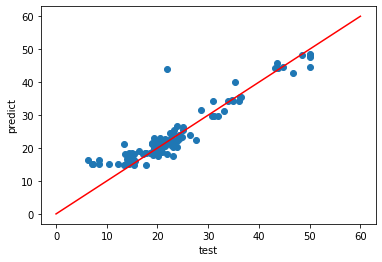

In [17]:
plt.scatter(y_test, pred)
plt.plot(np.linspace(0, 60, 100), np.linspace(0, 60, 100), "red")
plt.xlabel('test')
plt.ylabel('predict')
plt.show()

In [18]:
# feature importance のプロット
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.DataFrame(model.feature_importance(), index=[X.columns], columns=['importance'])


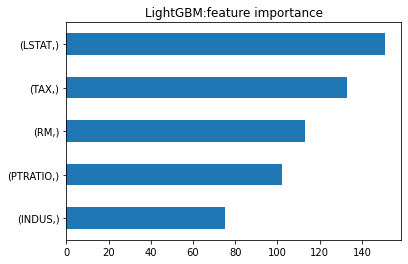

In [19]:
importances = importances['importance'].sort_values()
importances.plot(kind = 'barh')
plt.title('LightGBM:feature importance')
plt.show()

In [20]:
with open('lgbm_boston.model', 'wb') as f:
  pickle.dump(model, f)

## 結果
### 課題3
### クロスバリデーション
#### r2: 0.8376781023734997
#### rmse: 3.752752469634236
#### 
### 未知のデータ
#### r2: 0.82796698209147
#### rmse: 3.4708760937782275

## LightGBM
### クロスバリデーション
#### r2: 0.8904202496694168
#### rmse: 2.769203775439702

#### 
### 未知のデータ
#### r2: 0.8714826464394737
#### rmse: 3.6413214578191297


#### Scikit-learn APIはTraining APIに比べて細かな調整ができないことがある？